***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.1)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training with $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_2_7')

FOLDER CREATED =  ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_7


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 24
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
780/781 [============================>.] - ETA: 0s - loss: 0.2759 - prediction_coarse_accuracy: 0.8615 - prediction_medium_accuracy: 0.4330 - prediction_fine_accuracy: 0.2512
  • Coarse Accuracy = 86.15% | Val_Accuracy = 90.66% | LossWeight = 0.15 
  • Medium Accuracy = 43.33% | Val_Accuracy = 51.98% | LossWeight = 0.43 
  • Fine   Accuracy = 25.14% | Val_Accuracy = 34.09% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.34090, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 57s 62ms/step - loss: 0.2759 - prediction_coarse_accuracy: 0.8615 - prediction_medium_accuracy: 0.4333 - prediction_fine_accuracy: 0.2514 - val_loss: 0.2043 - val_prediction_coarse_accuracy: 0.9066 - val_prediction_medium_accuracy: 0.5198 - val_prediction_fine_accuracy: 0.3409 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1524 - prediction_coarse_accuracy: 0.9083 -

781/781 [==============================] - 43s 55ms/step - loss: 0.0745 - prediction_coarse_accuracy: 0.9660 - prediction_medium_accuracy: 0.8870 - prediction_fine_accuracy: 0.8359 - val_loss: 0.0504 - val_prediction_coarse_accuracy: 0.9709 - val_prediction_medium_accuracy: 0.8773 - val_prediction_fine_accuracy: 0.8299 - lr: 0.0010
Epoch 10/100
780/781 [============================>.] - ETA: 0s - loss: 0.0718 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.8941 - prediction_fine_accuracy: 0.8456
  • Coarse Accuracy = 96.81% | Val_Accuracy = 97.67% | LossWeight = 0.17 
  • Medium Accuracy = 89.41% | Val_Accuracy = 89.33% | LossWeight = 0.40 
  • Fine   Accuracy = 84.56% | Val_Accuracy = 84.69% | LossWeight = 0.43 

Epoch 10: val_prediction_fine_accuracy improved from 0.82990 to 0.84690, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 43s 55ms/step - loss: 0.0718 - prediction_coarse_accuracy: 0.9681 - 

781/781 [==============================] - 43s 55ms/step - loss: 0.0552 - prediction_coarse_accuracy: 0.9800 - prediction_medium_accuracy: 0.9395 - prediction_fine_accuracy: 0.9139 - val_loss: 0.0373 - val_prediction_coarse_accuracy: 0.9814 - val_prediction_medium_accuracy: 0.9099 - val_prediction_fine_accuracy: 0.8771 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0545 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9417 - prediction_fine_accuracy: 0.9172
  • Coarse Accuracy = 97.95% | Val_Accuracy = 98.18% | LossWeight = 0.19 
  • Medium Accuracy = 94.17% | Val_Accuracy = 91.31% | LossWeight = 0.39 
  • Fine   Accuracy = 91.72% | Val_Accuracy = 87.88% | LossWeight = 0.42 

Epoch 19: val_prediction_fine_accuracy improved from 0.87710 to 0.87880, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 43s 55ms/step - loss: 0.0545 - prediction_coarse_accuracy: 0.979

Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0500 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9561 - prediction_fine_accuracy: 0.9428
  • Coarse Accuracy = 98.26% | Val_Accuracy = 98.60% | LossWeight = 0.22 
  • Medium Accuracy = 95.61% | Val_Accuracy = 92.58% | LossWeight = 0.39 
  • Fine   Accuracy = 94.28% | Val_Accuracy = 89.67% | LossWeight = 0.38 

Epoch 28: val_prediction_fine_accuracy improved from 0.89070 to 0.89670, saving model to ../../logs/3_CIFAR_10/HD_CapsNet/Mod_2_7\epoch-best.h5
781/781 [==============================] - 43s 55ms/step - loss: 0.0500 - prediction_coarse_accuracy: 0.9826 - prediction_medium_accuracy: 0.9561 - prediction_fine_accuracy: 0.9428 - val_loss: 0.0321 - val_prediction_coarse_accuracy: 0.9860 - val_prediction_medium_accuracy: 0.9258 - val_prediction_fine_accuracy: 0.8967 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0497 - prediction_coarse_accuracy

781/781 [==============================] - 43s 55ms/step - loss: 0.0481 - prediction_coarse_accuracy: 0.9830 - prediction_medium_accuracy: 0.9607 - prediction_fine_accuracy: 0.9513 - val_loss: 0.0311 - val_prediction_coarse_accuracy: 0.9858 - val_prediction_medium_accuracy: 0.9310 - val_prediction_fine_accuracy: 0.9018 - lr: 2.5034e-04
Epoch 38/100
780/781 [============================>.] - ETA: 0s - loss: 0.0474 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9618 - prediction_fine_accuracy: 0.9515
  • Coarse Accuracy = 98.36% | Val_Accuracy = 98.52% | LossWeight = 0.24 
  • Medium Accuracy = 96.17% | Val_Accuracy = 92.50% | LossWeight = 0.39 
  • Fine   Accuracy = 95.15% | Val_Accuracy = 89.61% | LossWeight = 0.37 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.90180
781/781 [==============================] - 43s 55ms/step - loss: 0.0474 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.9515 - 

780/781 [============================>.] - ETA: 0s - loss: 0.0464 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9645 - prediction_fine_accuracy: 0.9577
  • Coarse Accuracy = 98.44% | Val_Accuracy = 98.74% | LossWeight = 0.25 
  • Medium Accuracy = 96.46% | Val_Accuracy = 93.06% | LossWeight = 0.40 
  • Fine   Accuracy = 95.77% | Val_Accuracy = 90.24% | LossWeight = 0.36 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.90420
781/781 [==============================] - 44s 56ms/step - loss: 0.0464 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.9577 - val_loss: 0.0297 - val_prediction_coarse_accuracy: 0.9874 - val_prediction_medium_accuracy: 0.9306 - val_prediction_fine_accuracy: 0.9024 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0468 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9581
  • Coar

781/781 [==============================] - 43s 55ms/step - loss: 0.0466 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9643 - prediction_fine_accuracy: 0.9579 - val_loss: 0.0293 - val_prediction_coarse_accuracy: 0.9865 - val_prediction_medium_accuracy: 0.9312 - val_prediction_fine_accuracy: 0.9031 - lr: 9.4468e-05
Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0465 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9571
  • Coarse Accuracy = 98.36% | Val_Accuracy = 98.64% | LossWeight = 0.25 
  • Medium Accuracy = 96.37% | Val_Accuracy = 93.29% | LossWeight = 0.40 
  • Fine   Accuracy = 95.71% | Val_Accuracy = 90.45% | LossWeight = 0.35 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.90520
781/781 [==============================] - 43s 55ms/step - loss: 0.0465 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9571 - 

780/781 [============================>.] - ETA: 0s - loss: 0.0463 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9593
  • Coarse Accuracy = 98.48% | Val_Accuracy = 98.72% | LossWeight = 0.25 
  • Medium Accuracy = 96.50% | Val_Accuracy = 93.28% | LossWeight = 0.40 
  • Fine   Accuracy = 95.93% | Val_Accuracy = 90.41% | LossWeight = 0.35 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.90640
781/781 [==============================] - 43s 55ms/step - loss: 0.0463 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9650 - prediction_fine_accuracy: 0.9593 - val_loss: 0.0289 - val_prediction_coarse_accuracy: 0.9872 - val_prediction_medium_accuracy: 0.9328 - val_prediction_fine_accuracy: 0.9041 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0459 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9590
  • Coar

781/781 [==============================] - 43s 55ms/step - loss: 0.0463 - prediction_coarse_accuracy: 0.9848 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9602 - val_loss: 0.0286 - val_prediction_coarse_accuracy: 0.9872 - val_prediction_medium_accuracy: 0.9339 - val_prediction_fine_accuracy: 0.9054 - lr: 3.5648e-05
Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0452 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9619
  • Coarse Accuracy = 98.51% | Val_Accuracy = 98.72% | LossWeight = 0.26 
  • Medium Accuracy = 96.71% | Val_Accuracy = 93.51% | LossWeight = 0.40 
  • Fine   Accuracy = 96.19% | Val_Accuracy = 90.63% | LossWeight = 0.35 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.90690
781/781 [==============================] - 43s 56ms/step - loss: 0.0452 - prediction_coarse_accuracy: 0.9851 - prediction_medium_accuracy: 0.9671 - prediction_fine_accuracy: 0.9619 - 

Epoch 85/100
781/781 [==============================] - ETA: 0s - loss: 0.0462 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.9594
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.69% | LossWeight = 0.25 
  • Medium Accuracy = 96.46% | Val_Accuracy = 93.51% | LossWeight = 0.40 
  • Fine   Accuracy = 95.94% | Val_Accuracy = 90.65% | LossWeight = 0.35 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.90810
781/781 [==============================] - 43s 55ms/step - loss: 0.0462 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9646 - prediction_fine_accuracy: 0.9594 - val_loss: 0.0287 - val_prediction_coarse_accuracy: 0.9869 - val_prediction_medium_accuracy: 0.9351 - val_prediction_fine_accuracy: 0.9065 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0455 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9658 - prediction_fine_accuracy: 0.

781/781 [==============================] - 43s 56ms/step - loss: 0.0452 - prediction_coarse_accuracy: 0.9855 - prediction_medium_accuracy: 0.9660 - prediction_fine_accuracy: 0.9604 - val_loss: 0.0280 - val_prediction_coarse_accuracy: 0.9878 - val_prediction_medium_accuracy: 0.9362 - val_prediction_fine_accuracy: 0.9071 - lr: 1.3452e-05
Epoch 95/100
780/781 [============================>.] - ETA: 0s - loss: 0.0452 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9612
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.78% | LossWeight = 0.26 
  • Medium Accuracy = 96.59% | Val_Accuracy = 93.60% | LossWeight = 0.40 
  • Fine   Accuracy = 96.13% | Val_Accuracy = 90.67% | LossWeight = 0.34 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.90810
781/781 [==============================] - 43s 55ms/step - loss: 0.0452 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9613 - 

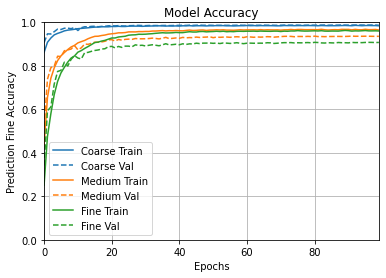

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

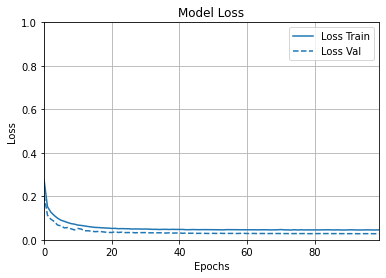

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 6s 15ms/step - loss: 0.0457 - prediction_coarse_loss: 0.0104 - prediction_medium_loss: 0.0481 - prediction_fine_loss: 0.0696 - prediction_coarse_accuracy: 0.9868 - prediction_medium_accuracy: 0.9358 - prediction_fine_accuracy: 0.9077
1. loss ==> 0.045734938234090805
2. prediction_coarse_loss ==> 0.010367518290877342
3. prediction_medium_loss ==> 0.048060283064842224
4. prediction_fine_loss ==> 0.06964841485023499
5. prediction_coarse_accuracy ==> 0.9868000149726868
6. prediction_medium_accuracy ==> 0.9358000159263611
7. prediction_fine_accuracy ==> 0.9077000021934509
313/313 [==============================] - 4s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

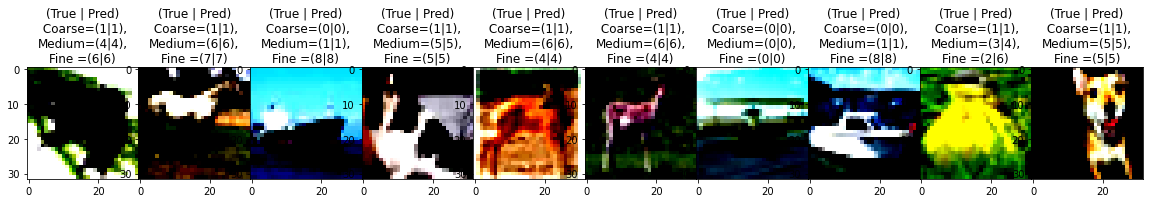

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3949   51]
 [  81 5919]]

  • MEDIUM LEVEL 
[[ 936   18   17   12    5    8    4]
 [  32  940   22    2    1    3    0]
 [  12    4 1973    3    3    5    0]
 [  24    2    2  877   21   39   35]
 [   6    2    3   18  941   26    4]
 [  13    4   13   45   43 1817   65]
 [  11    1    5   39   17   53 1874]]

  • FINE LEVEL 
[[941   4  12   7   1   0   5   2  17  11]
 [  4 964   1   2   0   1   1   0   0  27]
 [ 25   0 879  21  23  13  22  13   2   2]
 [ 11   2  29 789  21  82  36  17   5   8]
 [  5   0  30  22 899   9  18  15   1   1]
 [  4   0  23 104  19 829   9   9   1   2]
 [  7   1  18  19   3   5 942   1   2   2]
 [  6   1  10  13  20   6   0 942   0   2]
 [ 34   7   2   3   0   0   1   0 939  14]
 [  8  26   2   3   0   0   2   0   6 953]]

  • Classification Report 


  • COARSE LEVEL 


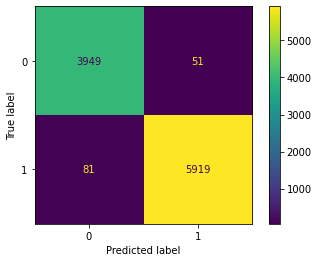

              precision    recall  f1-score   support

           0    0.97990   0.98725   0.98356      4000
           1    0.99146   0.98650   0.98897      6000

    accuracy                        0.98680     10000
   macro avg    0.98568   0.98687   0.98627     10000
weighted avg    0.98683   0.98680   0.98681     10000


  • MEDIUM LEVEL 


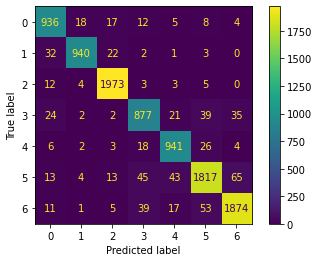

              precision    recall  f1-score   support

           0    0.90522   0.93600   0.92035      1000
           1    0.96807   0.94000   0.95383      1000
           2    0.96953   0.98650   0.97794      2000
           3    0.88052   0.87700   0.87876      1000
           4    0.91271   0.94100   0.92664      1000
           5    0.93132   0.90850   0.91977      2000
           6    0.94551   0.93700   0.94124      2000

    accuracy                        0.93580     10000
   macro avg    0.93041   0.93229   0.93122     10000
weighted avg    0.93592   0.93580   0.93575     10000


  • FINE LEVEL 


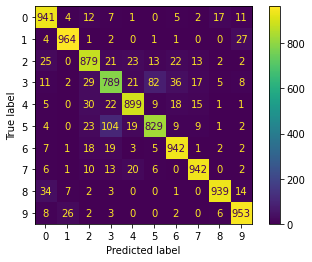

              precision    recall  f1-score   support

           0    0.90048   0.94100   0.92029      1000
           1    0.95920   0.96400   0.96160      1000
           2    0.87376   0.87900   0.87637      1000
           3    0.80264   0.78900   0.79576      1000
           4    0.91176   0.89900   0.90534      1000
           5    0.87725   0.82900   0.85244      1000
           6    0.90927   0.94200   0.92534      1000
           7    0.94294   0.94200   0.94247      1000
           8    0.96506   0.93900   0.95185      1000
           9    0.93249   0.95300   0.94263      1000

    accuracy                        0.90770     10000
   macro avg    0.90748   0.90770   0.90741     10000
weighted avg    0.90748   0.90770   0.90741     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9431666666666666 
Hierarchical Recall = 0.9444 
Hierarchical F1-Score = 0.9436809523809525 
Consistency =  0.993 
Exact Match =  0.9055
